<a href="https://colab.research.google.com/github/airoca/Boundary-Unlearning/blob/main/Boundary_Unlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Machine (un)Learning on CIFAR10**

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **1. Original Model & Retrain Model**

**1.1. (Original Model) Train a ResNet18 model on the CIFAR10 dataset. Report the accuracy of each class in the test set: airplanes, cars,birds, cats, deer, dogs, frogs, horses, ships, and trucks.**

In [ ]:
from torchvision.models import resnet18

path = '/content/drive/My Drive/net_model.pth'

net = resnet18(pretrained=False, num_classes=10)
net.load_state_dict(torch.load(path))

<ipython-input-5-1dfd1c50d03c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.007
[1,   200] loss: 0.008
[1,   300] loss: 0.009
[1,   400] loss: 0.010
[1,   500] loss: 0.011
[2,   100] loss: 0.006
[2,   200] loss: 0.006
[2,   300] loss: 0.006
[2,   400] loss: 0.008
[2,   500] loss: 0.010
[3,   100] loss: 0.006
[3,   200] loss: 0.005
[3,   300] loss: 0.006
[3,   400] loss: 0.006
[3,   500] loss: 0.007
[4,   100] loss: 0.005
[4,   200] loss: 0.005
[4,   300] loss: 0.005
[4,   400] loss: 0.005
[4,   500] loss: 0.006
[5,   100] loss: 0.003
[5,   200] loss: 0.003
[5,   300] loss: 0.003
[5,   400] loss: 0.004
[5,   500] loss: 0.004
[6,   100] loss: 0.003
[6,   200] loss: 0.003
[6,   300] loss: 0.003
[6,   400] loss: 0.003
[6,   500] loss: 0.004
[7,   100] loss: 0.003
[7,   200] loss: 0.003
[7,   300] loss: 0.003
[7,   400] loss: 0.003
[7,   500] loss: 0.004
[8,   100] loss: 0.003
[8,   200] loss: 0.003
[8,   300] loss: 0.003
[8,   400] loss: 0.003
[8,   500] loss: 0.004
[9,   100] loss: 0.003
[9,   200] loss: 0.002
[9,   300] loss: 0.003
[9,   400] 

In [ ]:
from google.colab import drive
import os

path = '/content/drive/My Drive/net_model.pth'

torch.save(net.state_dict(), path)

print(f'Model saved to {path}')

Model saved to /content/drive/My Drive/net_model.pth


In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the test set: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the test set: 62 %
Accuracy of plane : 65 %
Accuracy of   car : 78 %
Accuracy of  bird : 50 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 40 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 75 %
Accuracy of truck : 62 %


In [ ]:
test_correct = 0
test_total = 0
test_class_correct = list(0. for i in range(10))
test_class_total = list(0. for i in range(10))
test_ship_correct = 0
test_ship_total = 0
test_non_ship_correct = 0
test_non_ship_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            test_class_correct[label] += c[i].item()
            test_class_total[label] += 1
            if label == 8:
                test_ship_correct += c[i].item()
                test_ship_total += 1
            else:
                test_non_ship_correct += c[i].item()
                test_non_ship_total += 1
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print('Accuracy of retrain set on test set: %.2f %%' % (100 * test_non_ship_correct / test_non_ship_total))
print('Accuracy of forget set dataset on test set: %.2f %%' % (100 * test_ship_correct / test_ship_total))

train_correct = 0
train_total = 0
train_class_correct = list(0. for i in range(10))
train_class_total = list(0. for i in range(10))
train_ship_correct = 0
train_ship_total = 0
train_non_ship_correct = 0
train_non_ship_total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            train_class_correct[label] += c[i].item()
            train_class_total[label] += 1
            if label == 8:
                train_ship_correct += c[i].item()
                train_ship_total += 1
            else:
                train_non_ship_correct += c[i].item()
                train_non_ship_total += 1
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

print('Accuracy of retrain set on train set: %.2f %%' % (100 * train_non_ship_correct / train_non_ship_total))
print('Accuracy of forget set on train set: %.2f %%' % (100 * train_ship_correct / train_ship_total))

Accuracy of retrain set on test set: 60.72 %
Accuracy of forget set dataset on test set: 74.50 %
Accuracy of retrain set on train set: 98.79 %
Accuracy of forget set on train set: 99.18 %


In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap

layer = net._modules.get('avgpool')
intermediate_representations = []

def hook(module, input, output):
    intermediate_representations.append(output.detach().cpu().numpy())

hook_handle = layer.register_forward_hook(hook)

net.eval()
with torch.no_grad():
    for data in testloader:
        images, _ = data
        outputs = net(images)

intermediate_representations = np.concatenate(intermediate_representations, axis=0).reshape(len(testset), -1)

reducer = umap.UMAP()
embedding = reducer.fit_transform(intermediate_representations)

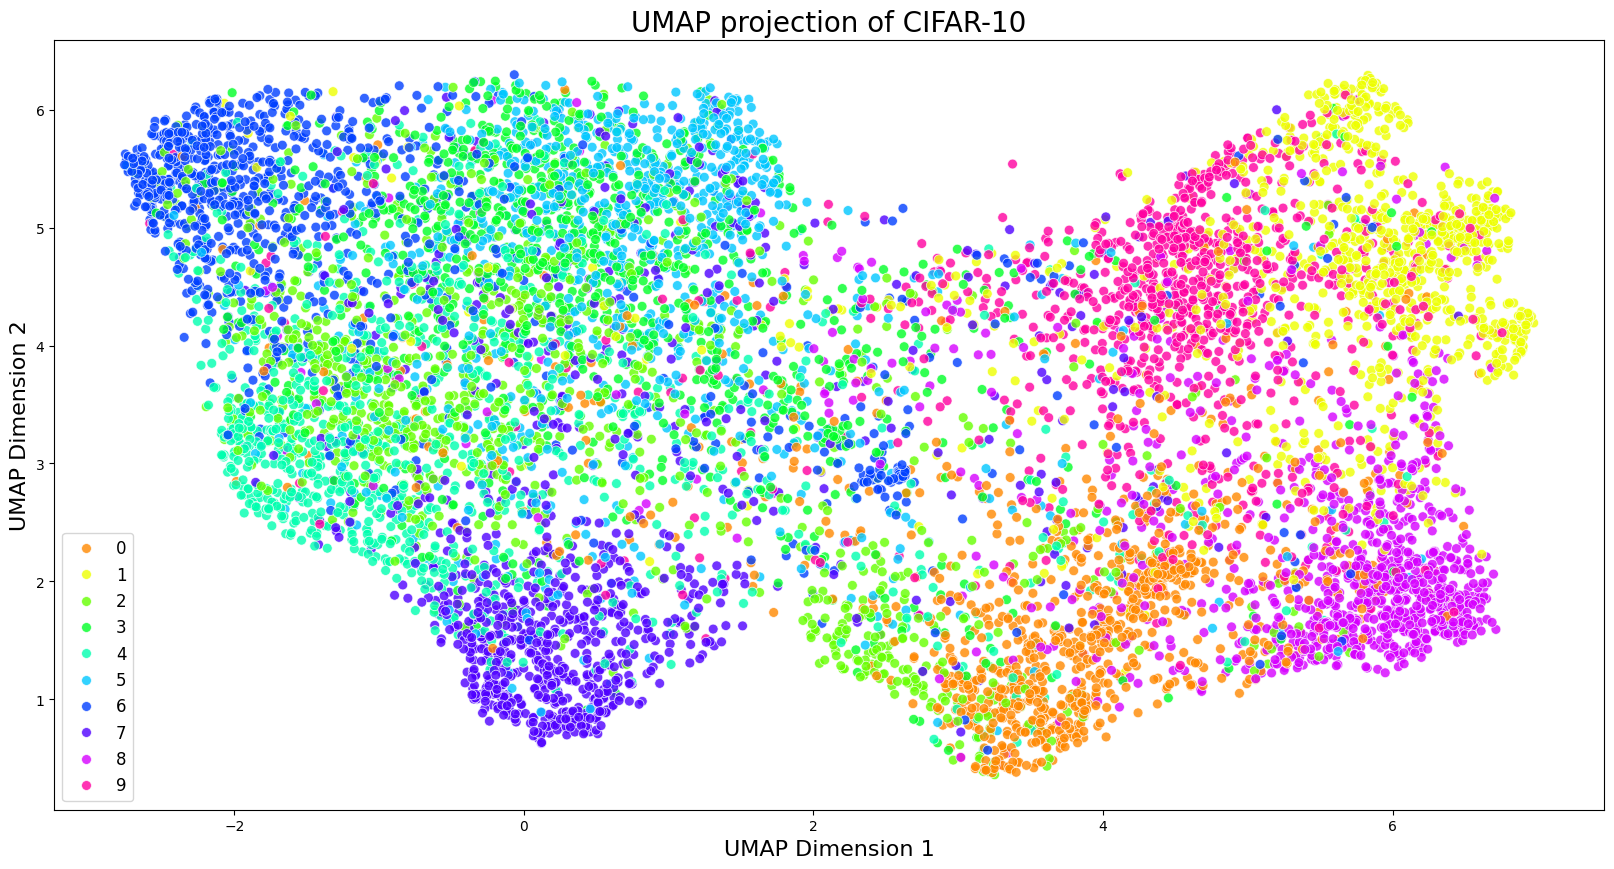

In [ ]:
plt.figure(figsize=(20, 10), dpi=100)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=testset.targets, palette=sns.color_palette("hsv", 10), legend='full', s=50, alpha=0.8)
plt.title('UMAP projection of CIFAR-10', fontsize=20)
plt.xlabel('UMAP Dimension 1', fontsize=16)
plt.ylabel('UMAP Dimension 2', fontsize=16)
plt.legend(fontsize=12)
plt.show()

hook_handle.remove()

**1.2. (Retrain Model) Train a ResNet18 model with 9 classes (defined as a retain set), except the class “ships” (defined as a forget set).**

In [ ]:
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

In [9]:
def filter_dataset(dataset, exclude_class):
    filtered_data = []
    filtered_labels = []
    for data, label in dataset:
        if label != exclude_class:
            filtered_data.append(data)
            filtered_labels.append(label)
    return filtered_data, filtered_labels

train_data, train_labels = filter_dataset(trainset, 8)
test_data, test_labels = filter_dataset(testset, 8)

train_retrain_set = [(train_data[i], train_labels[i]) for i in range(len(train_data))]
test_retrain_set = [(test_data[i], test_labels[i]) for i in range(len(test_data))]

trainloader_retrain = torch.utils.data.DataLoader(train_retrain_set, batch_size=100,
                                                  shuffle=True, num_workers=2)
testloader_retrain = torch.utils.data.DataLoader(test_retrain_set, batch_size=100,
                                                 shuffle=False, num_workers=2)

def filter_class_dataset(dataset, target_class):
    filtered_data = []
    filtered_labels = []
    for data, label in dataset:
        if label == target_class:
            filtered_data.append(data)
            filtered_labels.append(label)
    return filtered_data, filtered_labels

train_data_ship, train_labels_ship = filter_class_dataset(trainset, 8)
test_data_ship, test_labels_ship = filter_class_dataset(testset, 8)

train_forget_set = [(train_data_ship[i], train_labels_ship[i]) for i in range(len(train_data_ship))]
test_forget_set = [(test_data_ship[i], test_labels_ship[i]) for i in range(len(test_data_ship))]

trainloader_forget = torch.utils.data.DataLoader(train_forget_set, batch_size=100,
                                                 shuffle=True, num_workers=2)
testloader_forget = torch.utils.data.DataLoader(test_forget_set, batch_size=100,
                                                shuffle=False, num_workers=2)

In [ ]:
retrain_net = resnet18(pretrained=False, num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrain_net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader_retrain, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = retrain_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Retrain Training')

[1,   100] loss: 0.098
[1,   200] loss: 0.080
[1,   300] loss: 0.075
[1,   400] loss: 0.071
[2,   100] loss: 0.063
[2,   200] loss: 0.063
[2,   300] loss: 0.061
[2,   400] loss: 0.061
[3,   100] loss: 0.054
[3,   200] loss: 0.053
[3,   300] loss: 0.054
[3,   400] loss: 0.052
[4,   100] loss: 0.044
[4,   200] loss: 0.045
[4,   300] loss: 0.046
[4,   400] loss: 0.046
[5,   100] loss: 0.037
[5,   200] loss: 0.038
[5,   300] loss: 0.039
[5,   400] loss: 0.038
[6,   100] loss: 0.028
[6,   200] loss: 0.030
[6,   300] loss: 0.032
[6,   400] loss: 0.033
[7,   100] loss: 0.023
[7,   200] loss: 0.023
[7,   300] loss: 0.026
[7,   400] loss: 0.026
[8,   100] loss: 0.017
[8,   200] loss: 0.018
[8,   300] loss: 0.019
[8,   400] loss: 0.021
[9,   100] loss: 0.013
[9,   200] loss: 0.013
[9,   300] loss: 0.015
[9,   400] loss: 0.016
[10,   100] loss: 0.009
[10,   200] loss: 0.009
[10,   300] loss: 0.010
[10,   400] loss: 0.012
Finished Retrain Training


In [ ]:
from google.colab import drive
import os

path = '/content/drive/My Drive/retrain_model.pth'

torch.save(retrain_net.state_dict(), path)

print(f'Model saved to {path}')

Model saved to /content/drive/My Drive/retrain_model.pth


In [ ]:
def evaluate_model(net, dataloader, classes, class_map):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(class_map)))
    class_total = list(0. for i in range(len(class_map)))

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i].item()
                if label in class_map:
                    mapped_label = class_map[label]
                    class_correct[mapped_label] += c[i].item()
                    class_total[mapped_label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    overall_accuracy = 100 * correct / total
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(len(class_map))]
    return overall_accuracy, class_accuracies

# all classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# all classes except ship
retrain_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'truck')

# class mapping
class_map_retrain = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 9:8}
class_map_forget = {8:0}

# training retrain set
train_retrain_accuracy, train_retrain_class_accuracies = evaluate_model(retrain_net, trainloader_retrain, retrain_classes, class_map_retrain)
print('Train Retrain Set Accuracy: %.2f %%' % train_retrain_accuracy)
for i, acc in enumerate(train_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# test retrain set
test_retrain_accuracy, test_retrain_class_accuracies = evaluate_model(retrain_net, testloader_retrain, retrain_classes, class_map_retrain)
print('Test Retrain Set Accuracy: %.2f %%' % test_retrain_accuracy)
for i, acc in enumerate(test_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# training forget set ("ship class")
train_forget_accuracy, train_forget_class_accuracies = evaluate_model(retrain_net, trainloader_forget, ['ship'], class_map_forget)
print('Train Forget Set (ship) Accuracy: %.2f %%' % train_forget_accuracy)

# test forget set ("ship class")
test_forget_accuracy, test_forget_class_accuracies = evaluate_model(retrain_net, testloader_forget, ['ship'], class_map_forget)
print('Test Forget Set (ship) Accuracy: %.2f %%' % test_forget_accuracy)

Train Retrain Set Accuracy: 94.13 %
Accuracy of plane : 96 %
Accuracy of   car : 93 %
Accuracy of  bird : 94 %
Accuracy of   cat : 92 %
Accuracy of  deer : 91 %
Accuracy of   dog : 90 %
Accuracy of  frog : 93 %
Accuracy of horse : 98 %
Accuracy of truck : 97 %
Test Retrain Set Accuracy: 60.14 %
Accuracy of plane : 74 %
Accuracy of   car : 67 %
Accuracy of  bird : 48 %
Accuracy of   cat : 44 %
Accuracy of  deer : 48 %
Accuracy of   dog : 44 %
Accuracy of  frog : 67 %
Accuracy of horse : 74 %
Accuracy of truck : 71 %
Train Forget Set (ship) Accuracy: 0.00 %
Test Forget Set (ship) Accuracy: 0.00 %


## **2. Random Labels Baseline**

**Implement the “Random Labels” method (described in the paper) and evaluate the machine unlearning performance for the following dataset:**

**training forget set, training retrain set, test forget set, and test retrain set.**

**Note: Random Labels method is to finetune the Original Model by randomly assigning the class label to forget set so that it never outputs the forget set (“ships”) result.**

In [ ]:
#after original model is trained and saved

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import torch
import torchvision
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/net_model.pth'

net = resnet18(pretrained=False, num_classes=10)
net.load_state_dict(torch.load(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-17-90d189ffcbf3>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
import copy

# copy original model
net_label = copy.deepcopy(net)

In [ ]:
import random

# random seed set to 42
random.seed(42)

train_forget_set_random = [(data, random.choice([i for i in range(10) if i != 8])) for data, label in train_forget_set]
trainloader_forget_random = torch.utils.data.DataLoader(train_forget_set_random, batch_size=100, shuffle=True, num_workers=2)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_label.parameters(), lr=0.001, momentum=0.9)

# fine-tuning
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader_forget_random, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net_label(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Fine-tuning with Random Labels')

Finished Fine-tuning with Random Labels


In [ ]:
def evaluate_model(net, dataloader, classes, class_map):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(class_map)))
    class_total = list(0. for i in range(len(class_map)))

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i].item()
                if label in class_map:
                    mapped_label = class_map[label]
                    class_correct[mapped_label] += c[i].item()
                    class_total[mapped_label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    overall_accuracy = 100 * correct / total
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(len(class_map))]
    return overall_accuracy, class_accuracies

# class mapping
class_map_retrain = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 9:8}
class_map_forget = {8:0}

# training retrain set
train_retrain_accuracy, train_retrain_class_accuracies = evaluate_model(net_label, trainloader_retrain, retrain_classes, class_map_retrain)
print('Train Retrain Set Accuracy: %.2f %%' % train_retrain_accuracy)
for i, acc in enumerate(train_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# test retrain set
test_retrain_accuracy, test_retrain_class_accuracies = evaluate_model(net_label, testloader_retrain, retrain_classes, class_map_retrain)
print('Test Retrain Set Accuracy: %.2f %%' % test_retrain_accuracy)
for i, acc in enumerate(test_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# training forget set ("ship class")
train_forget_accuracy, train_forget_class_accuracies = evaluate_model(net_label, trainloader_forget, ['ship'], class_map_forget)
print('Train Forget Set (ship) Accuracy: %.2f %%' % train_forget_accuracy)

# test forget set ("ship class")
test_forget_accuracy, test_forget_class_accuracies = evaluate_model(net_label, testloader_forget, ['ship'], class_map_forget)
print('Test Forget Set (ship) Accuracy: %.2f %%' % test_forget_accuracy)

Train Retrain Set Accuracy: 25.39 %
Accuracy of plane : 22 %
Accuracy of   car : 29 %
Accuracy of  bird : 24 %
Accuracy of   cat : 19 %
Accuracy of  deer : 26 %
Accuracy of   dog : 22 %
Accuracy of  frog : 27 %
Accuracy of horse : 26 %
Accuracy of truck : 29 %
Test Retrain Set Accuracy: 19.28 %
Accuracy of plane : 18 %
Accuracy of   car : 22 %
Accuracy of  bird : 17 %
Accuracy of   cat : 11 %
Accuracy of  deer : 20 %
Accuracy of   dog : 15 %
Accuracy of  frog : 20 %
Accuracy of horse : 20 %
Accuracy of truck : 25 %
Train Forget Set (ship) Accuracy: 0.00 %
Test Forget Set (ship) Accuracy: 0.00 %


## **3. Boundary Shrink Method**

**Using trained model, the task now is to make it forget the class “ships” using only 50% and 100% of the class “ships” images from the training dataset.**

**(The less images used, the better they are for the unlearning.)**

**Adversarial attacks (PGD or FGSM) are implemented to generate adversarial samples.**

In [4]:
from torchvision.models import resnet18

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/net_model.pth'

net = resnet18(pretrained=False, num_classes=10)
net.load_state_dict(torch.load(path))

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-808c5853d7f9>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

<All keys matched successfully>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions


class AttackBase(object):
    def __init__(self, model=None, norm=False, discrete=True, device=None):
        self.model = model
        self.norm = norm
        # Normalization are needed for CIFAR10, ImageNet
        if self.norm:
            self.mean = (0.4914, 0.4822, 0.2265)
            self.std = (0.2023, 0.1994, 0.2010)
        self.discrete = discrete
        self.device = device or torch.device("cuda:0")
        self.loss(device=self.device)

    def loss(self, custom_loss=None, device=None):
        device = device or self.device
        self.criterion = custom_loss or nn.CrossEntropyLoss()
        self.criterion.to(device)

    def perturb(self, x):
        raise NotImplementedError

    def normalize(self, x):
        if self.norm:
            y = x.clone().to(x.device)
            y[:, 0, :, :] = (y[:, 0, :, :] - self.mean[0]) / self.std[0]
            y[:, 1, :, :] = (y[:, 1, :, :] - self.mean[1]) / self.std[1]
            y[:, 2, :, :] = (y[:, 2, :, :] - self.mean[2]) / self.std[2]
            return y
        return x

    def inverse_normalize(self, x):
        if self.norm:
            y = x.clone().to(x.device)
            y[:, 0, :, :] = y[:, 0, :, :] * self.std[0] + self.mean[0]
            y[:, 1, :, :] = y[:, 1, :, :] * self.std[1] + self.mean[1]
            y[:, 2, :, :] = y[:, 2, :, :] * self.std[2] + self.mean[2]
            return y
        return x

    def discretize(self, x):
        return torch.round(x * 255) / 255

    # Change this name as "projection"
    def clamper(self, x_adv, x_nat, bound=None, metric="inf", inverse_normalized=False):
        if not inverse_normalized:
            x_adv = self.inverse_normalize(x_adv)
            x_nat = self.inverse_normalize(x_nat)
        if metric == "inf":
            clamp_delta = torch.clamp(x_adv - x_nat, -bound, bound)
        else:
            clamp_delta = x_adv - x_nat
            for batch_index in range(clamp_delta.size(0)):
                image_delta = clamp_delta[batch_index]
                image_norm = image_delta.norm(p=metric, keepdim=False)
                # TODO: channel isolation?
                if image_norm > bound:
                    clamp_delta[batch_index] /= image_norm
                    clamp_delta[batch_index] *= bound
        x_adv = x_nat + clamp_delta
        x_adv = torch.clamp(x_adv, 0., 1.)
        return self.normalize(self.discretize(x_adv)).clone().detach().requires_grad_(True)


class FGSM(AttackBase):
    def __init__(self, model=None, bound=None, norm=False, random_start=False, discrete=True, device=None, **kwargs):
        super(FGSM, self).__init__(model, norm, discrete, device)
        self.bound = bound
        self.rand = random_start

    def perturb(self, x, y, model=None, bound=None, device=None, **kwargs):
        criterion = self.criterion
        model = model or self.model
        bound = bound or self.bound
        device = device or self.device

        model.zero_grad()
        x_nat = self.inverse_normalize(x.detach().clone().to(device))
        x_adv = x.detach().clone().requires_grad_(True).to(device)
        if self.rand:
            rand_perturb_dist = distributions.uniform.Uniform(-bound, bound)
            rand_perturb = rand_perturb_dist.sample(sample_shape=x_adv.shape).to(device)
            x_adv = self.clamper(self.inverse_normalize(x_adv) + rand_perturb, x_nat, bound=bound,
                                 inverse_normalized=True)
            if self.discretize:
                x_adv = self.normalize(self.discretize(x_adv)).detach().clone().requires_grad_(True)
            else:
                x_adv = self.normalize(x_adv).detach().clone().requires_grad_(True)

        pred = model(x_adv)
        if criterion.__class__.__name__ == "NLLLoss":
            pred = F.softmax(pred, dim=-1)
        loss = criterion(pred, y)
        loss.backward()

        grad_sign = x_adv.grad.data.detach().sign()
        x_adv = self.inverse_normalize(x_adv) + grad_sign * bound
        x_adv = self.clamper(x_adv, x_nat, bound=bound, inverse_normalized=True)

        return x_adv.detach()


class LinfPGD(AttackBase):
    def __init__(self, model=None, bound=None, step=None, iters=None, norm=False, random_start=False, discrete=True,
                 device=None, **kwargs):
        super(LinfPGD, self).__init__(model, norm, discrete, device)
        self.bound = bound
        self.step = step
        self.iter = iters
        self.rand = random_start


    def perturb(self, x, y, target_y=None, model=None, bound=None, step=None, iters=None, x_nat=None, device=None,
                **kwargs):
        criterion = self.criterion
        model = model or self.model
        bound = bound or self.bound
        step = step or self.step
        iters = iters or self.iter
        device = device or self.device

        model.zero_grad()
        if x_nat is None:
            x_nat = self.inverse_normalize(x.detach().clone().to(device))
        else:
            x_nat = self.inverse_normalize(x_nat.detach().clone().to(device))
        x_adv = x.detach().clone().requires_grad_(True).to(device)
        if self.rand:
            rand_perturb_dist = distributions.uniform.Uniform(-bound, bound)
            rand_perturb = rand_perturb_dist.sample(sample_shape=x_adv.shape).to(device)
            x_adv = self.clamper(self.inverse_normalize(x_adv) + rand_perturb, self.inverse_normalize(x_nat),
                                 bound=bound, inverse_normalized=True)
            if self.discretize:
                x_adv = self.normalize(self.discretize(x_adv)).detach().clone().requires_grad_(True)
            else:
                x_adv = self.normalize(x_adv).detach().clone().requires_grad_(True)

        for i in range(iters):
            adv_pred = model(x_adv)
            ori_pred = model(x)
            delta_pred = adv_pred - ori_pred
            if criterion.__class__.__name__ == "NLLLoss":
                delta_pred = F.log_softmax(delta_pred, dim=-1)
            # loss =   0.1*criterion(pred, target_y) - criterion(pred, original_y)
            if target_y is not None:
                # loss = criterion(adv_pred, y)
                loss = - criterion(delta_pred, target_y)  # + 0.01*criterion(delta_pred, y)
            else:
                loss = criterion(adv_pred, y)
            loss.backward()

            grad_sign = x_adv.grad.data.detach().sign()
            x_adv = self.inverse_normalize(x_adv) + grad_sign * step
            x_adv = self.clamper(x_adv, x_nat, bound=bound, inverse_normalized=True)
            model.zero_grad()

        return x_adv.detach().to(device)


def inf_generator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [2]:
import copy
import numpy as np
import torch
from torch import nn
import tqdm
import time

def boundary_shrink(ori_model, train_forget_loader, dt, dv, test_loader, device, evaluate,
                    bound=0.1, step=8 / 255, iter=5, poison_epoch=10, forget_class=0, path='./',
                    extra_exp=None, lambda_=0.7, bias=-0.5, slope=5.0):
    start = time.time()
    norm = True  # None#True if data_name != "mnist" else False
    random_start = False  # False if attack != "pgd" else True

    test_model = copy.deepcopy(ori_model).to(device)
    unlearn_model = copy.deepcopy(ori_model).to(device)
    start_time = time.time()
    # adv = LinfPGD(test_model, bound, step, iter, norm, random_start, device)
    adv = FGSM(test_model, bound, norm, random_start, device)
    forget_data_gen = inf_generator(train_forget_loader)
    batches_per_epoch = len(train_forget_loader)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(unlearn_model.parameters(), lr=0.00001, momentum=0.9)

    num_hits = 0
    num_sum = 0
    nearest_label = []

    for itr in tqdm.tqdm(range(poison_epoch * batches_per_epoch)):

        x, y = forget_data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        test_model.eval()
        x_adv = adv.perturb(x, y, target_y=None, model=test_model, device=device)
        adv_logits = test_model(x_adv)
        pred_label = torch.argmax(adv_logits, dim=1)
        if itr >= (poison_epoch - 1) * batches_per_epoch:
            nearest_label.append(pred_label.tolist())
        num_hits += (y != pred_label).float().sum()
        num_sum += y.shape[0]

        # adv_train
        unlearn_model.train()
        unlearn_model.zero_grad()
        optimizer.zero_grad()

        ori_logits = unlearn_model(x)
        ori_loss = criterion(ori_logits, pred_label)

        # loss = ori_loss  # - KL_div
        if extra_exp == 'curv':
            ori_curv = curvature(ori_model, x, y, h=0.9)[1]
            cur_curv = curvature(unlearn_model, x, y, h=0.9)[1]
            delta_curv = torch.norm(ori_curv - cur_curv, p=2)
            loss = ori_loss + lambda_ * delta_curv  # - KL_div
        elif extra_exp == 'weight_assign':
            weight = weight_assign(adv_logits, pred_label, bias=bias, slope=slope)
            ori_loss = (torch.nn.functional.cross_entropy(ori_logits, pred_label, reduction='none') * weight).mean()
            loss = ori_loss
        else:
            loss = ori_loss  # - KL_div
        loss.backward()
        optimizer.step()

    print('attack success ratio:', (num_hits / num_sum).float())
    # print(nearest_label)
    print('boundary shrink time:', (time.time() - start_time))
    # np.save('nearest_label', nearest_label)
    torch.save(unlearn_model, '{}boundary_shrink_unlearn_model.pth'.format(path))

    return unlearn_model

In [11]:
device = "cpu"

# copy net model as net_boundary
net_boundary = copy.deepcopy(net)

dt = train_forget_set_50
dv = test_forget_set
evaluate = True

# "ship" 50% boundary shrink
train_forget_set_50 = train_forget_set[:len(train_forget_set)//2]
trainloader_forget_50 = torch.utils.data.DataLoader(train_forget_set_50, batch_size=100, shuffle=True, num_workers=2)
net_boundary_50 = boundary_shrink(net_boundary, trainloader_forget_50, dt, dv, testloader, device, evaluate, bound=0.1, step=8/255, iter=5, poison_epoch=10)

# "ship" 100% boundary shrink
trainloader_forget_100 = torch.utils.data.DataLoader(train_forget_set, batch_size=100, shuffle=True, num_workers=2)
net_boundary_100 = boundary_shrink(net_boundary, trainloader_forget_100, dt, dv, testloader, device, evaluate, bound=0.1, step=8/255, iter=5, poison_epoch=10)

100%|██████████| 250/250 [10:44<00:00,  2.58s/it]


attack success ratio: tensor(0.9964)
boundary shrink time: 644.4692628383636


100%|██████████| 500/500 [22:39<00:00,  2.72s/it]


attack success ratio: tensor(0.9970)
boundary shrink time: 1359.1791245937347


In [12]:
from google.colab import drive
import os
import tarfile

drive.mount('/content/drive')

path = '/content/drive/My Drive/net_boundary_50.pth'
torch.save(net_boundary_50.state_dict(), path)

path = '/content/drive/My Drive/net_boundary_100.pth'
torch.save(net_boundary_100.state_dict(), path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
path = '/content/drive/My Drive/net_boundary_50.pth'
net_boundary_50 = resnet18(pretrained=False, num_classes=10)
net_boundary_50.load_state_dict(torch.load(path))

path = '/content/drive/My Drive/net_boundary_100.pth'
net_boundary_100 = resnet18(pretrained=False, num_classes=10)
net_boundary_100.load_state_dict(torch.load(path))

<ipython-input-13-10d8788a5183>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_boundary_50.load_state_dict(torch.load(path))
<ipython-input-13-10d8788a5183>:7: FutureW

<All keys matched successfully>

**Accuracy for all 10 classes for the following datasets: training forget set, training retain set, test forget set, and test retain set.**

In [14]:
def evaluate_model(net, dataloader, classes, class_map):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(class_map)))
    class_total = list(0. for i in range(len(class_map)))

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):  # 배치 크기만큼 반복
                label = labels[i].item()
                if label in class_map:
                    mapped_label = class_map[label]
                    class_correct[mapped_label] += c[i].item()
                    class_total[mapped_label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    overall_accuracy = 100 * correct / total
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(len(class_map))]
    return overall_accuracy, class_accuracies

# all classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# all classes except ship
retrain_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'truck')

# class mapping
class_map_retrain = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 9:8}
class_map_forget = {8:0}

In [15]:
print("Ships Images 50%\n")

# training retrain set
train_retrain_accuracy, train_retrain_class_accuracies = evaluate_model(net_boundary_50, trainloader_retrain, retrain_classes, class_map_retrain)
print('Train Retrain Set Accuracy: %.2f %%' % train_retrain_accuracy)
for i, acc in enumerate(train_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# test retrain set
test_retrain_accuracy, test_retrain_class_accuracies = evaluate_model(net_boundary_50, testloader_retrain, retrain_classes, class_map_retrain)
print('Test Retrain Set Accuracy: %.2f %%' % test_retrain_accuracy)
for i, acc in enumerate(test_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# training forget set ("ship class")
train_forget_accuracy, train_forget_class_accuracies = evaluate_model(net_boundary_50, trainloader_forget, ['ship'], class_map_forget)
print('Train Forget Set (ship) Accuracy: %.2f %%' % train_forget_accuracy)

# test forget set ("ship class")
test_forget_accuracy, test_forget_class_accuracies = evaluate_model(net_boundary_50, testloader_forget, ['ship'], class_map_forget)
print('Test Forget Set (ship) Accuracy: %.2f %%' % test_forget_accuracy)

Ships Images 50%

Train Retrain Set Accuracy: 94.62 %
Accuracy of plane : 99 %
Accuracy of   car : 99 %
Accuracy of  bird : 90 %
Accuracy of   cat : 92 %
Accuracy of  deer : 92 %
Accuracy of   dog : 93 %
Accuracy of  frog : 93 %
Accuracy of horse : 95 %
Accuracy of truck : 94 %
Test Retrain Set Accuracy: 57.36 %
Accuracy of plane : 80 %
Accuracy of   car : 82 %
Accuracy of  bird : 39 %
Accuracy of   cat : 40 %
Accuracy of  deer : 46 %
Accuracy of   dog : 41 %
Accuracy of  frog : 63 %
Accuracy of horse : 63 %
Accuracy of truck : 58 %
Train Forget Set (ship) Accuracy: 4.82 %
Test Forget Set (ship) Accuracy: 6.00 %


In [16]:
print("Ships Images 100%\n")

# training retrain set
train_retrain_accuracy, train_retrain_class_accuracies = evaluate_model(net_boundary_100, trainloader_retrain, retrain_classes, class_map_retrain)
print('Train Retrain Set Accuracy: %.2f %%' % train_retrain_accuracy)
for i, acc in enumerate(train_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# test retrain set
test_retrain_accuracy, test_retrain_class_accuracies = evaluate_model(net_boundary_100, testloader_retrain, retrain_classes, class_map_retrain)
print('Test Retrain Set Accuracy: %.2f %%' % test_retrain_accuracy)
for i, acc in enumerate(test_retrain_class_accuracies):
    print('Accuracy of %5s : %2d %%' % (retrain_classes[i], acc))

# training forget set ("ship class")
train_forget_accuracy, train_forget_class_accuracies = evaluate_model(net_boundary_100, trainloader_forget, ['ship'], class_map_forget)
print('Train Forget Set (ship) Accuracy: %.2f %%' % train_forget_accuracy)

# test forget set ("ship class")
test_forget_accuracy, test_forget_class_accuracies = evaluate_model(net_boundary_100, testloader_forget, ['ship'], class_map_forget)
print('Test Forget Set (ship) Accuracy: %.2f %%' % test_forget_accuracy)

Ships Images 100%

Train Retrain Set Accuracy: 88.98 %
Accuracy of plane : 97 %
Accuracy of   car : 99 %
Accuracy of  bird : 81 %
Accuracy of   cat : 83 %
Accuracy of  deer : 84 %
Accuracy of   dog : 86 %
Accuracy of  frog : 84 %
Accuracy of horse : 89 %
Accuracy of truck : 92 %
Test Retrain Set Accuracy: 53.62 %
Accuracy of plane : 79 %
Accuracy of   car : 84 %
Accuracy of  bird : 35 %
Accuracy of   cat : 32 %
Accuracy of  deer : 39 %
Accuracy of   dog : 37 %
Accuracy of  frog : 56 %
Accuracy of horse : 58 %
Accuracy of truck : 58 %
Train Forget Set (ship) Accuracy: 2.24 %
Test Forget Set (ship) Accuracy: 4.50 %


**Visualize the results using UMAP.**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


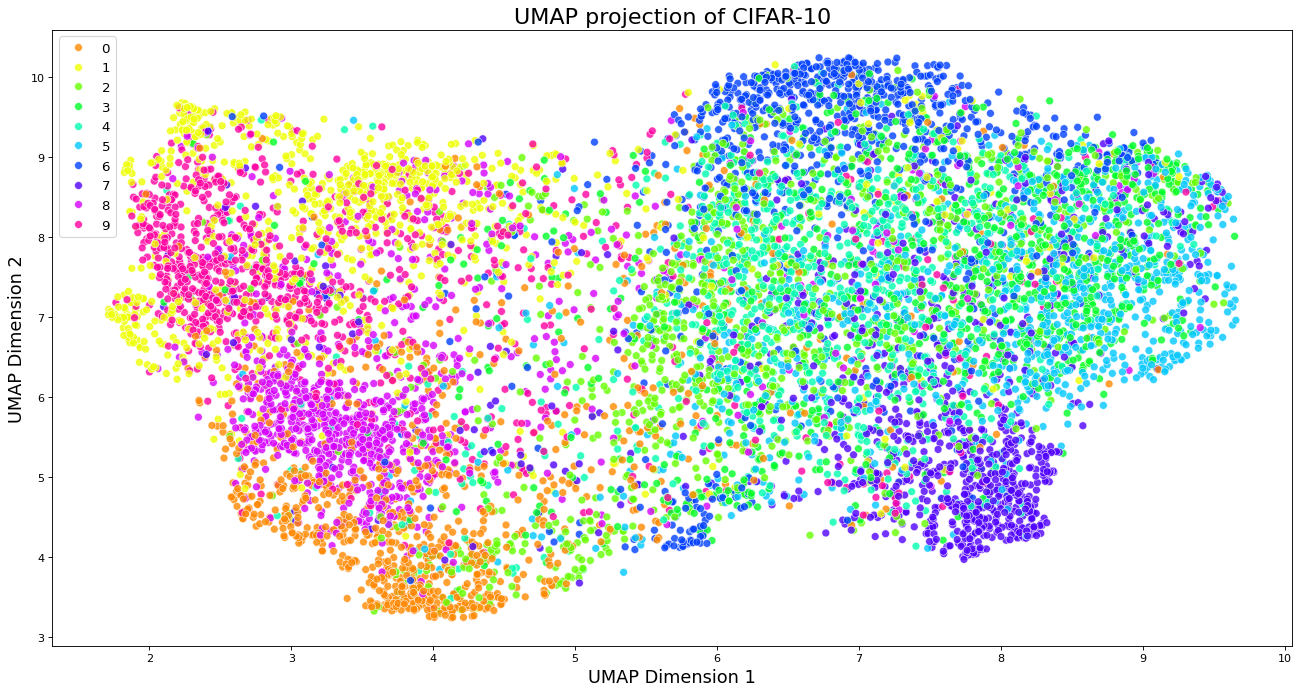

In [28]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# extract intermediate representations
layer = net_boundary_50._modules.get('avgpool')
intermediate_representations = []

def hook(module, input, output):
    intermediate_representations.append(output.detach().cpu().numpy())

hook_handle = layer.register_forward_hook(hook)

# run through test data to get intermediate representations
net_boundary_50.eval()
with torch.no_grad():
    for data in testloader:
        images, _ = data
        outputs = net_boundary_50(images)

intermediate_representations = np.concatenate(intermediate_representations, axis=0).reshape(len(testset), -1)

# apply UMAP for dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(intermediate_representations)

# Increase the size and resolution of the plot
plt.figure(figsize=(20, 10), dpi=80)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=testset.targets, palette=sns.color_palette("hsv", 10), legend='full', s=50, alpha=0.8)
plt.title('UMAP projection of CIFAR-10', fontsize=20)
plt.xlabel('UMAP Dimension 1', fontsize=16)
plt.ylabel('UMAP Dimension 2', fontsize=16)
plt.legend(fontsize=12)
plt.show()

hook_handle.remove()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


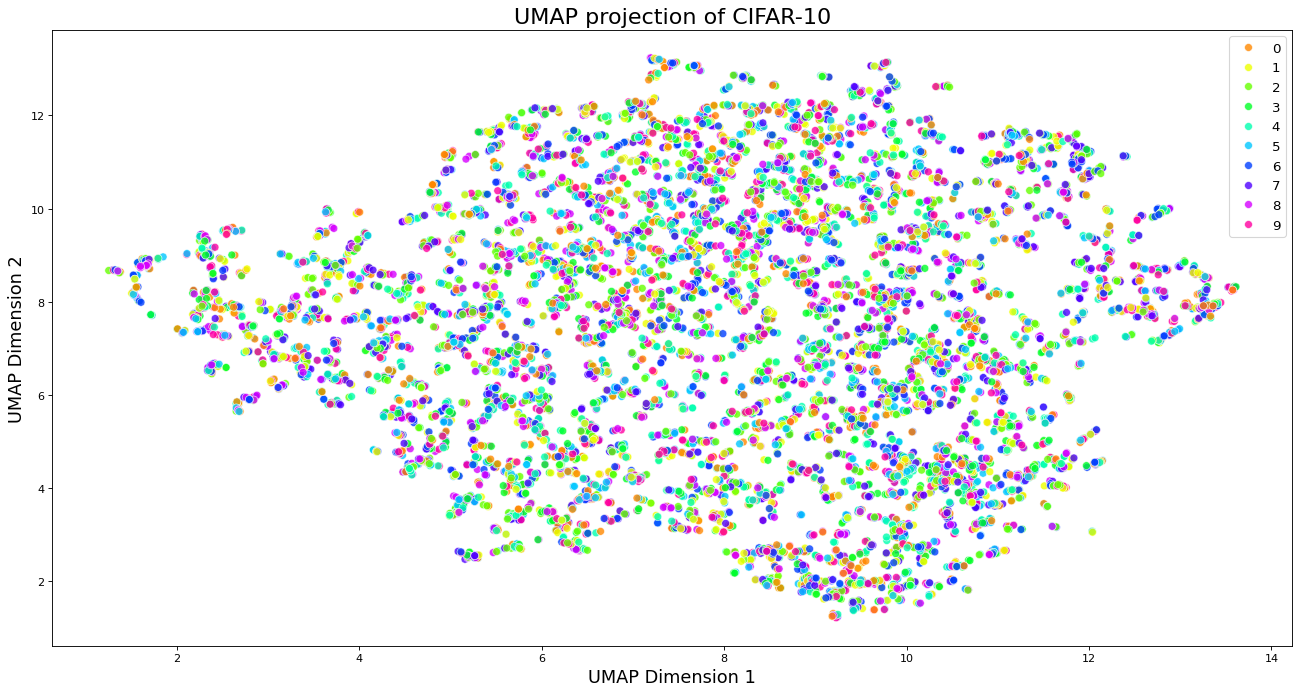

In [29]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# extract intermediate representations
layer = net_boundary_100._modules.get('avgpool')
intermediate_representations = []

def hook(module, input, output):
    intermediate_representations.append(output.detach().cpu().numpy())

hook_handle = layer.register_forward_hook(hook)

# run through test data to get intermediate representations
net_boundary_100.eval()
with torch.no_grad():
    for data in testloader:
        images, _ = data
        outputs = net_boundary_100(images)

intermediate_representations = np.concatenate(intermediate_representations, axis=0).reshape(len(testset), -1)

# apply UMAP for dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(intermediate_representations)

# Increase the size and resolution of the plot
plt.figure(figsize=(20, 10), dpi=80)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=testset.targets, palette=sns.color_palette("hsv", 10), legend='full', s=50, alpha=0.8)
plt.title('UMAP projection of CIFAR-10', fontsize=20)
plt.xlabel('UMAP Dimension 1', fontsize=16)
plt.ylabel('UMAP Dimension 2', fontsize=16)
plt.legend(fontsize=12)
plt.show()

hook_handle.remove()

**Accuracy Performance vs. Training Data used for Unlearning**

| Ships Images</br>used for unlearning | Train Retrain Set Accuracy (%) | Test Retrain Set Accuracy (%) | Train Forget Set Accuracy (%) | Test Forget Set Accuracy (%) |
| --- | --- | --- | --- | --- |
| 50% | 94.62 % | 57.36 % | 4.82 % | 6.00 % |
| 100% | 88.98 % | 53.62 % | 2.24 % | 4.50 % |

## **4. Result Comparison and Analysis**

**Single table to compare the performance of Original Model, Retrain Model, Random Labels Model, and Boundary Shrink Model for the following datasets: training forget set, training retain set, test forget set, and test retain set.**

| Model | Train Retain Set Accuracy (%) | Test Retrain Set Accuracy (%) | Train Forget Set Accuracy (%) | Test Forget Set Accuracy (%) |
| --- | --- | --- | --- | --- |
| Original | 98.79 % | 60.72 % | 99.18 % | 74.50 % |
| Retrain | 94.13 % | 60.14 % | 0.00 % | 0.00 % |
| Random Labels | 25.39 % | 19.28 % | 0.00 % | 0.00 % |
| Boundary Shrink (50%) | 94.62 % | 57.36 % | 4.82 % | 6.00 % |
| Boundary Shrink (100%) | 88.98 % | 53.62 % | 2.24 % | 4.50 % |